# PyTorch Basics Tutorial

In this notebook, a simple fully connected neural network is implemented without using any neural network module of the PyTorch library. To be able to learn the weights and the biases of the network, the learnable parameters are defined using the PyTorch Tensor object and they are updated via PyTorch’s automatic differentiation engine named [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). In short, autograd retains a graph of operations applied to the tensors, which is called a computational graph. With the help of this graph, the gradients of the tensors can be calculated by applying the chain rule. Thanks to this feature, the gradients of the learnable parameters in a network can be calculated easily according to a loss function, and the parameters can be updated accordingly to fit the data better. 

This tutorial aims to explain the basics of PyTorch Tensor and how the gradients can be calculated using autograd. For this purpose, a dataset is created with a simple function, and a neural network is trained on it to estimate the labels from given features. Additionally, the importance of the activation functions and the network complexity for estimating the data is discussed by playing with the architecture of the network.

### Importing the Libraries Required

In [23]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

### Setting Library Seeds for Reproducibility

In [24]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [25]:
seed_everything(464) # The seed number is selected arbitrarily

### Dataset Creation

The dataset is sampled from a simple continuous function to be able to observe how well the network learns to predict the data. The function is decided to be $y=x^2$ in this tutorial and it is defined as a Python method below. It can be changed later to make experiments with different functions.

In [26]:
def function_to_be_learned(x):
    return x**2

In this and the following parts, the data is visualized in the range of -10 to 10. In order to show the continuous data, feature values (x) of 1000 samples are generated below by using [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function, which returns evenly spaced numbers within the specified range. Later, their corresponding labels (y) are generated and the continuous function that is going to be learned is visualized using Matplotlib library.

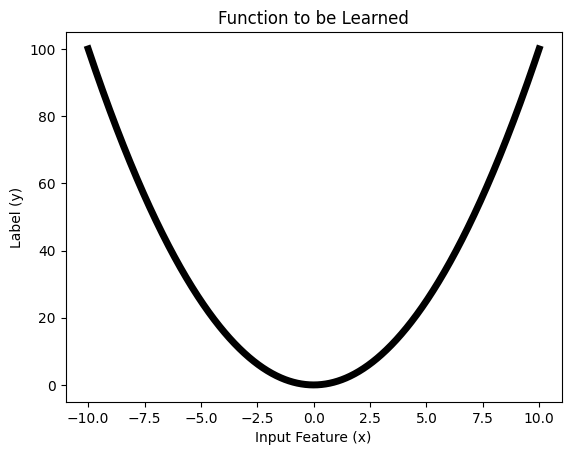

In [27]:
x = np.linspace(start=-10, stop=10, num=1000)
y = function_to_be_learned(x)
plt.plot(x, y, linewidth=5, color="black")
plt.xlabel("Input Feature (x)")
plt.ylabel("Label (y)")
plt.title("Function to be Learned")
plt.show()

The dataset is created by sampling data from the function. For sampling, [np.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) function is used to generate n random float values, where n is provided to the function, in the range of 0 to 1. To convert this range to $[-10, 10)$, the values are multiplied by 20, and 10 is subtracted from the resulting values. After obtaining these randomly generated feature values, they are sorted and their corresponding labels are found as before. In the end, both the feature (x) and the label (y) values are returned after they are converted to PyTorch tensor objects from NumPy array objects.

**Note:** As a general rule, the dataset should consist of rows and columns where the rows represent each sample and the columns represent each feature. Therefore, the shape of the randomly generated data is defined as (num_samples, 1), where 1 corresponds to the number of features, and sorting is applied on axis=0.

In [28]:
def create_data(num_samples=100):
    X = np.random.rand(num_samples, 1) * 20 - 10 
    X = np.sort(X, axis=0)
    y = function_to_be_learned(X)
    X, y = torch.Tensor(X), torch.Tensor(y)
    return X, y

In [29]:
X, y = create_data()

The sampled data is visualized below.

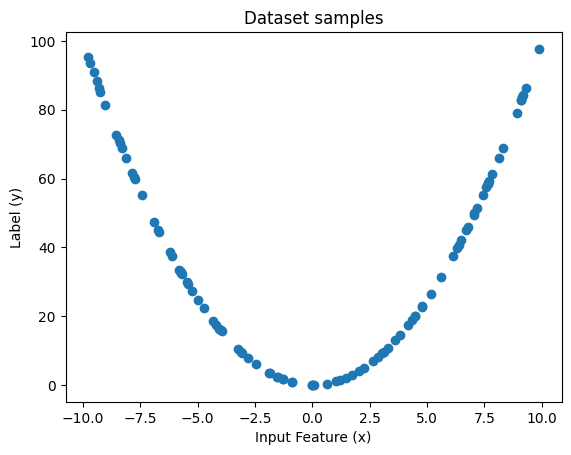

In [30]:
plt.scatter(X, y, color="tab:blue")
plt.xlabel("Input Feature (x)")
plt.ylabel("Label (y)")
plt.title("Dataset samples")
plt.show()

### Defining the Network Parameters

The architecture of a neural network with one hidden layer is shown below. Each gray arrow represents a weight, which is a learnable parameter. An arrow takes a value and multiplies it with its weight to generate the output value. Similarly, each red arrow represents a bias, which is also a learnable parameter. Red arrows take the sum of multiplied values from gray arrows and add their bias to them to shift the output. Green and yellow circles represent the input and the output values that consist of n and l dimensions respectively. The orange circle represents the hidden layer outputs with k dimensions, which is equal to the size of the hidden layer defined. Blue circles stand for the activation function defined in the network. They take the hidden layer outputs and generate the hidden layer activations. The activation functions are nonlinear functions that allow the network to learn nonlinear relations. If they are not defined, the application of the other calculations ends with a linear function, and in most cases, they fail to represent the real distribution of the data.

![Fully Connected Network](https://drive.google.com/uc?export=view&id=1lp4rWHWS3qIHDkSiKa1lN8AlnDRLt_rD)

Instead of applying weight multiplication and addition of bias one by one, the calculations are done using matrix operations to make the calculations faster. These operations can be generalized as $y = X \cdot W + b$, where X is the set of values of the previous layer and W is the weight matrix of the current layer that consists of all learnable weight parameters, gray arrows, in that layer. b is the vector of all biases, red arrows, which are also learnable parameters. y is the vector of values found for the next layer. The shapes of these matrices and vectors are defined below.

For simplicity, initial weights are sampled from the standard normal distribution using [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) and the initial biases are set to 0. These tensors are converted to Variable object later to activate the autograd calculations by setting requires_grad attribute to True. However, these calculations are defined in the Tensor object itself, including requires_grad, and Variables are [no longer used](https://pytorch.org/docs/stable/autograd.html#variable-deprecated) after PyTorch 0.4.0. In the newer versions of PyTorch, Variable returns a Tensor object. The defined learnable parameters are put into a list to make the gradient updates easier later.

In [31]:
input_size = 1
hidden_size = 1
output_size = 1

weights_1 = torch.randn(input_size, hidden_size)
bias_1 = torch.zeros(1, hidden_size)
weights_2 = torch.randn(hidden_size, output_size)
bias_2 = torch.zeros(1, output_size)

weights_1 = Variable(weights_1, requires_grad=True)
bias_1 = Variable(bias_1, requires_grad=True)
weights_2 = Variable(weights_2, requires_grad=True)
bias_2 = Variable(bias_2, requires_grad=True)

learning_rate = 0.001
learnable_parameters = [weights_1, bias_1, weights_2, bias_2]

### Defining the Gradient Operations

zero_grad function sets the all gradient values of the learnable parameters that are calculated automatically before to zero. Why it is needed is explained in the training loop cell. update_parameters function updates the learnable parameters by the gradients calculated. The magnitude of the update is determined by the learning_rate provided.

**Note:** torch.no_grad() disables all automatic gradient calculations inside its scope. Since it is unnecessary to keep the computational graph of the parameter updates, parameter update is done inside this scope.

In [32]:
def zero_grad(learnable_parameters):
    for parameter in learnable_parameters:
        if parameter.grad is not None:
            parameter.grad.zero_()

In [33]:
def update_parameters(learnable_parameters, learning_rate):
    with torch.no_grad():
        for parameter in learnable_parameters:
            parameter -= learning_rate * parameter.grad.data

### Defining the Activation and Loss Functions

The activation function is selected as Rectified Linear Unit (ReLU) in this tutorial. It is defined as a Python method below by using PyTorch functions. [torch.maximum](https://pytorch.org/docs/stable/generated/torch.maximum.html) takes maximum values by comparing two tensors and [torch.zeros_like](https://pytorch.org/docs/stable/generated/torch.zeros_like.html) creates a tensor with 0 values that has the same shape as the input tensor. The function is visualized as in the dataset visualization part. Differently, PyTorch tensors are used for input data generation and they are converted to NumPy array after obtaining the output data by calling the NumPy converter function [numpy()](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html) to plot the values.

In [34]:
def relu(x):
    output = torch.maximum(x, torch.zeros_like(x))
    return output

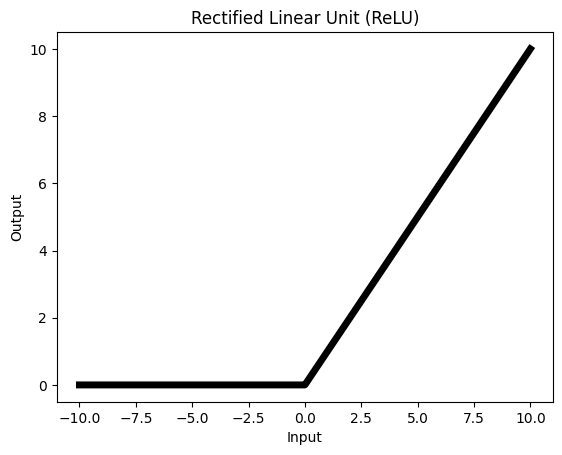

In [35]:
x = torch.linspace(start=-10, end=10, steps=1000)
y = relu(x)
plt.plot(x.numpy(), y.numpy(), linewidth=5, color="black")
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Rectified Linear Unit (ReLU)")
plt.show()

Mean Squared Error (MSE) is used as the loss function and defined as a Python method below. [torch.pow](https://pytorch.org/docs/stable/generated/torch.pow.html) Takes the power of input with the given exponent, which is 2 in our case to take the square, and [mean()](https://pytorch.org/docs/stable/generated/torch.Tensor.mean.html) returns the mean of the values inside the tensor.

In [36]:
def mse(y_pred, y):
    return torch.pow(y_pred-y, 2).mean()

### Training Loop

In each iteration, the predicted values are found by applying a forward pass with [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html), which are the matrix multiplications explained after the network figure. In this process, the computational graph is generated automatically because requires_grad attributes are set to True for the tensors of the weights and the biases. After predicting the label, the loss function, MSE, is called to find the between the predicted and the ground-truth values. This calculation is also included in the computational graph. 

In the end, the backward function of the loss tensor is called to calculate the gradients via autograd and store them in the corresponding tensors, which are the ones that exist in the computational graph. These gradients are calculated in the grad attributes of the tensors. When the update_parameters function is called, it takes the calculated gradients and updates the tensors accordingly. Since these gradients are not removed, when the backward function is called again in the following epoch, the gradients in the tensors are accumulated by default. To get rid of the gradients calculated in the previous epoch, the zero_grad function is called to set the gradients to zero before calculating the gradients of the next epoch.

In [37]:
num_epochs = 100

loss_list = []

for i in range(num_epochs):

    zero_grad(learnable_parameters)
    
    # Applying forward pass
    hidden_outputs = torch.matmul(X, weights_1) + bias_1
    hidden_activations = relu(hidden_outputs)
    y_pred = torch.matmul(hidden_activations, weights_2) + bias_2

    loss = mse(y_pred, y)
    loss.backward()

    update_parameters(learnable_parameters, learning_rate)
    
    loss_list.append(loss.item())

### Visualizing the Loss Curve

List comprehension is used to create the list of epoch numbers. The epoch numbers and their corresponding loss values are plotted below.

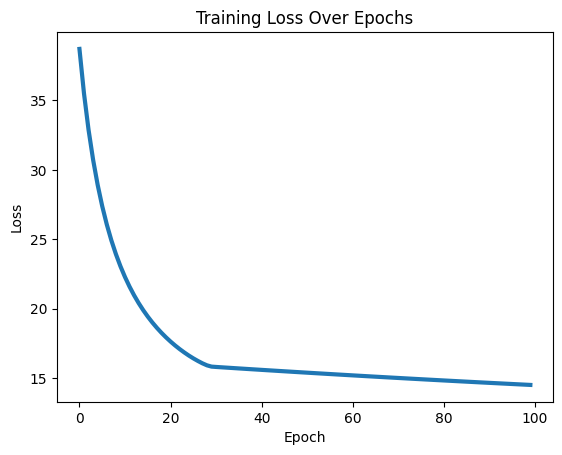

In [38]:
plot_x = [epoch for epoch in range(num_epochs)]
plot_y = loss_list
plt.plot(plot_x, plot_y, linewidth=3, color="tab:blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

### Putting Them All Together

In this part, all of the implementations explained before are put into a class to be able to create a model as an object and train it.

In [39]:
class MyModel():
    # The constructor, which is called when an object is being created. The values defined
    # for the parameters are the default values. When there is no value provided for them,
    # these values are used.
    def __init__(self, input_size=1, hidden_size=10, output_size=1, learning_rate=0.001):
        self.weights_1 = Variable(torch.randn(input_size, hidden_size), requires_grad=True)
        self.bias_1 = Variable(torch.zeros(1, hidden_size), requires_grad=True)
        self.weights_2 = Variable(torch.randn(hidden_size, output_size), requires_grad=True)
        self.bias_2 = Variable(torch.zeros(1, output_size), requires_grad=True)
        self.learnable_parameters = [self.weights_1, self.bias_1, self.weights_2, self.bias_2]
        self.learning_rate = learning_rate
    
    def relu(self, X):
        output = torch.maximum(X, torch.zeros_like(X))
        return output
    
    def zero_grad(self):
        for parameter in self.learnable_parameters:
            if parameter.grad is not None:
                parameter.grad.zero_()
    
    def update_parameters(self):
        with torch.no_grad():
            for parameter in self.learnable_parameters:
                parameter -= self.learning_rate * parameter.grad.data
    
    # Forward pass
    def __call__(self, X):
        hidden_outputs = torch.matmul(X, self.weights_1) + self.bias_1
        hidden_activations = self.relu(hidden_outputs)
        y_pred = torch.matmul(hidden_activations, self.weights_2) + self.bias_2
        return y_pred

In [40]:
seed_everything(0) # The seed number is selected arbitrarily
X, y = create_data()

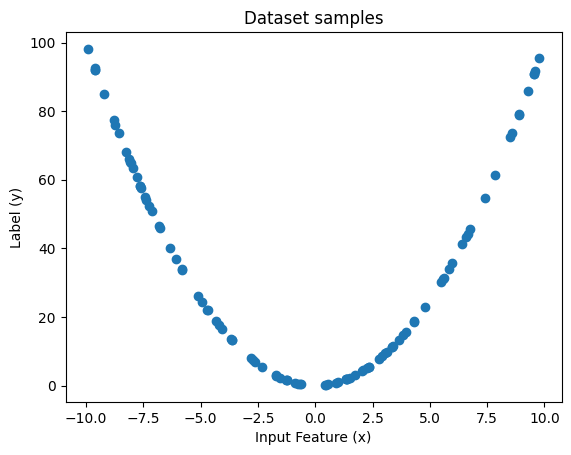

In [41]:
plt.scatter(X, y, color="tab:blue")
plt.xlabel("Input Feature (x)")
plt.ylabel("Label (y)")
plt.title("Dataset samples")
plt.show()

In [42]:
num_epochs = 10000

# The constructer (__init__) is called 
my_model = MyModel(input_size=1, hidden_size=20, output_size=1, learning_rate=0.001)

loss_list = []

for epoch in range(num_epochs):
    my_model.zero_grad()
    
    # The (__call__) function is called
    y_pred = my_model(X)
    
    loss = mse(y_pred, y)
    loss.backward()
    my_model.update_parameters()
    
    loss_list.append(loss.item())

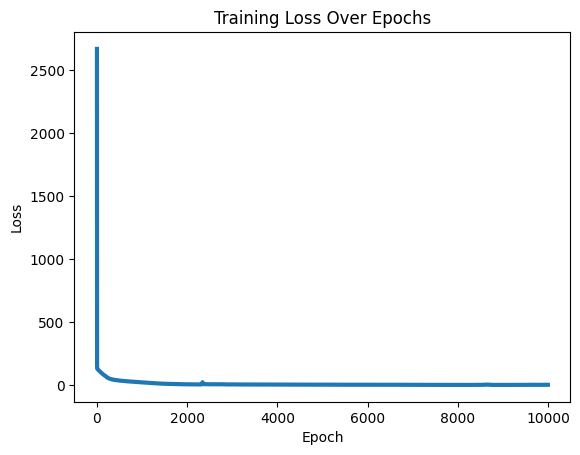

In [43]:
plot_x = [epoch for epoch in range(num_epochs)]
plot_y = loss_list
plt.plot(plot_x, plot_y, linewidth=3, color="tab:blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

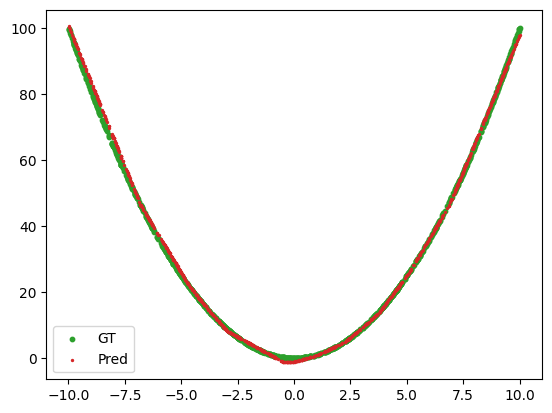

In [44]:
X, y = create_data(num_samples=1000)
# flatten() converts 2D matrix to 1D vector for visualization.
# detach() detaches the tensor from the computational graph 
# that is created in the forward pass to be able to convert
# the tensor to a NumPy array.
y_pred = my_model(X).flatten().detach().numpy()
X = X.flatten().numpy()

plt.scatter(X, y, s=10, color="tab:green", label="GT")
plt.scatter(X, y_pred, s=2, color="tab:red", label="Pred")
plt.legend()
plt.show()

You can play with the hyperparameters to observe the change in the learning process. Since this is a simple implementation, weight initialization is kept simple and there is no optimizer used, which makes the training process unstable as the model gets more complex. Keep it in mind in your trials.

---

**Author:** Ahmet Burak Yıldırım \[[GitHub](https://github.com/abyildirim)\] \[[LinkedIn](https://tr.linkedin.com/in/ahmet-burak-yildirim)\]

---